# Final Analysis March 16
1. For fig2C, I need the weights of feature ranking to classify age without Klotho (i.e. without ch4 and ch11). 
2. For fig2D, rug plot for CD63. Also the mean and variance
3. For fig2E, rug plot for cd81. Also the mean and variance
4. For fig3G, rug plot for Klotho. In this case, add intensity (your values) columns for alt-kl (ch4) and klotho (ch11) and then plot them. Also send me the mean and variance. 
5. For fig3I, linear regression based weights for prediction of klotho. Can you send me two sets of analysis here: prediction of only ch11 and prediction of ch4+ch11 
6. For fig3J, Correlation between cd82 and klotho. I can make this with the sheet you had sent me. 
7. For fig3K, the heat map like thing that you suggested where the rows are all features and columns are age and Klotho. I need numbers (weights?) to work with. 

I think for most analysis, let's consider Klotho intensity to be a sum of alt-kl (ch4) and klotho (ch11). 

In [6]:
% reload_ext autoreload
% autoreload 2
from feature_selector import FeatureSelector
from IPython.utils import io
import pandas as pd
from BioAnalysis import BioAnalysis
import numpy as np
from tqdm import tqdm, trange
from lightgbm import *
import sys
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import operator 
from collections import OrderedDict
from sklearn.linear_model import RANSACRegressor
from sklearn import preprocessing
from scipy.stats import fisher_exact
from IPython.display import HTML, display
from scipy.stats import mannwhitneyu
import csv
import sys
!{sys.executable} -m pip install -U scikit-learn
import seaborn as sns
from sklearn.cluster import *
from sklearn.mixture import *
from sklearn.linear_model import LinearRegression

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/ankitb/.local/lib/python2.7/site-packages (0.20.4)


In [7]:
db = pd.read_csv('../Amrita_29feb/features.csv')
analysis = BioAnalysis('../Amrita_29feb/')
points = analysis.points

In [8]:
columns = list(db.columns)
db['Index'] = db.Class*10000 + db['Object Number']
db.set_index('Index')
filtered = analysis.getFilteredIndices()
indices = filtered[:,0]*10000 + filtered[:,1]
indices = [int(index) for index in indices]
filtered_db = db.loc[indices,:]
filtered_db.Intensity_MC_Ch02 = points[:,0]
filtered_db.Intensity_MC_Ch07 = points[:,1]
filtered_db.Intensity_MC_Ch11 = points[:,2]
filtered_db.Intensity_MC_Ch04 = points[:,3]
filtered_db.Intensity_MC_Ch03 = points[:,4]
filtered_db['Intensity_MC_KL'] = filtered_db.Intensity_MC_Ch04 + filtered_db.Intensity_MC_Ch11
filtered_db_index = filtered_db[(filtered_db.Intensity_MC_KL<150) & (filtered_db.Intensity_MC_Ch07>5)].index

filtered_db.drop(filtered_db_index , inplace=True)
unfiltered_db = filtered_db

In [9]:
data = []
data.append('Class')
data.append('Object Number')
data.append('Area_M01')
data.append('Area_M02')
data.append('Area_M03')
data.append('Area_M04')
data.append('Area_M06')
data.append('Area_M07')
data.append('Area_M09')
data.append('Area_M11')
data.append('Aspect Ratio_M01')
data.append('Aspect Ratio_M06')
data.append('Aspect Ratio_M09')
data.append('Modulation_M02_Ch02')
data.append('Modulation_M03_Ch03')
data.append('Modulation_M07_Ch07')
data.append('Modulation_M04_Ch04')
data.append('Modulation_M11_Ch11')
data.append('Intensity_MC_Ch02')
data.append('Intensity_MC_Ch07')
data.append('Intensity_MC_Ch03')
data.append('Intensity_MC_Ch04')
data.append('Intensity_MC_Ch11')
data.append('Intensity_MC_KL')
data
filtered_db = unfiltered_db[data]
filtered_db.to_csv('filtered_db.csv')

## Fig. 2C: What features can predict age 

### Without KL

Note: both these following experiments contain Ch01 features. 

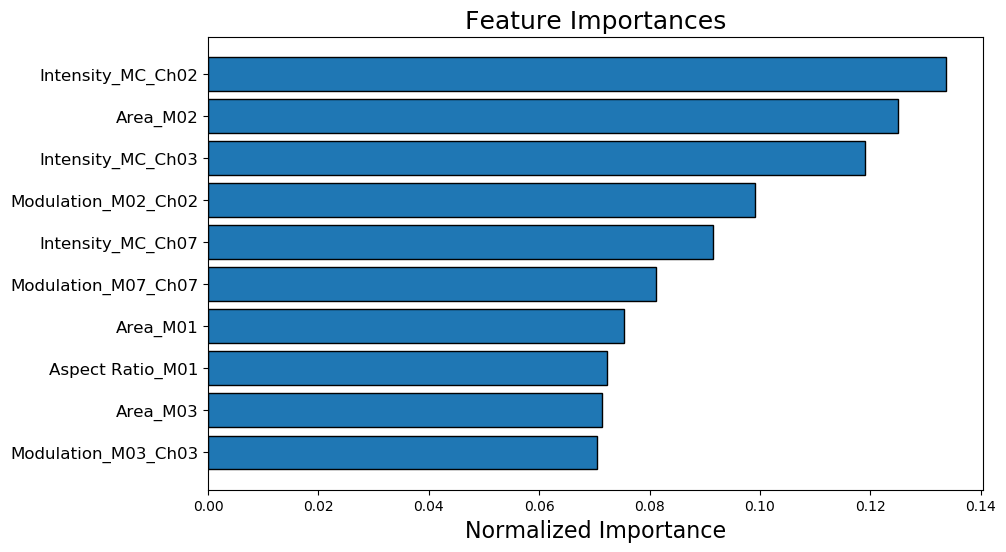

Cross-validation Accuracy: 0.75110785977
Cross-validation Variance: 0.00042433704065


,feature,importance,normalized_importance,cumulative_importance
0,Intensity_MC_Ch02,670.0,0.133733,0.133733
1,Area_M02,626.0,0.124950,0.258683
2,Intensity_MC_Ch03,596.0,0.118962,0.377645
3,Modulation_M02_Ch02,497.0,0.099202,0.476846
4,Intensity_MC_Ch07,458.0,0.091417,0.568263
5,Modulation_M07_Ch07,407.0,0.081238,0.649501
6,Area_M01,378.0,0.075449,0.724950
7,Aspect Ratio_M01,362.0,0.072255,0.797206
8,Area_M03,358.0,0.071457,0.868663
9,Modulation_M03_Ch03,353.0,0.070459,0.939122


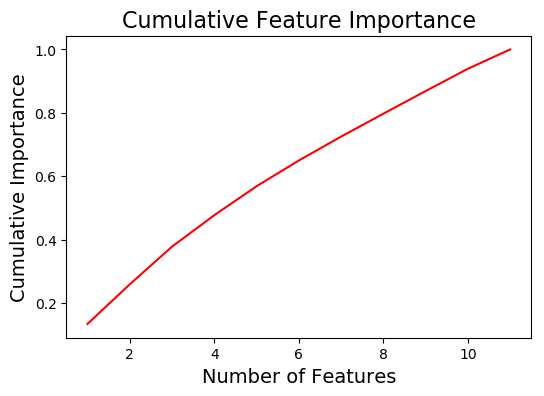

In [5]:
new_db = filtered_db
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)
X = X.drop([i for i in X.columns if "KL" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

with io.capture_output() as captured:
    fs = FeatureSelector(data = X, labels = Y)
    fs.identify_missing(missing_threshold=0.6);
    fs.identify_single_unique()
    fs.identify_collinear(correlation_threshold=0.975)
    # fs.plot_collinear(plot_all=True)
    fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                                n_iterations = 10, early_stopping = True)
fs.plot_feature_importances(plot_n = 12)

# Print the crossvalidation score:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=1)
s = cross_val_score(model, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Accuracy: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.var(s)))


features_0 = fs.feature_importances
fs.feature_importances

### with KL

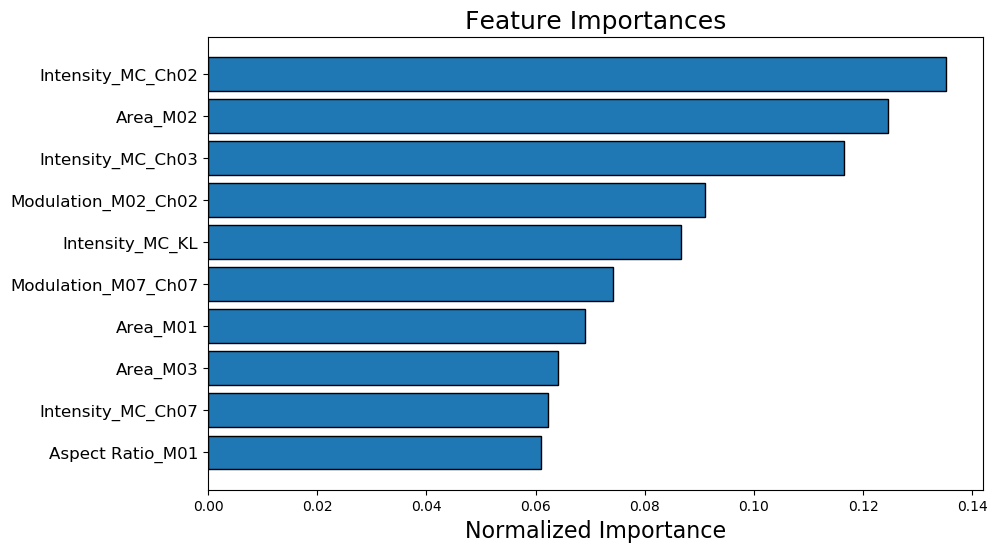

Cross-validation Accuracy: 0.754549746267
Cross-validation Variance: 0.000212789596171


,feature,importance,normalized_importance,cumulative_importance
0,Intensity_MC_Ch02,569.0,0.135187,0.135187
1,Area_M02,524.0,0.124495,0.259682
2,Intensity_MC_Ch03,490.0,0.116417,0.376099
3,Modulation_M02_Ch02,383.0,0.090995,0.467094
4,Intensity_MC_KL,365.0,0.086719,0.553813
5,Modulation_M07_Ch07,312.0,0.074127,0.627940
6,Area_M01,291.0,0.069138,0.697078
7,Area_M03,270.0,0.064148,0.761226
8,Intensity_MC_Ch07,262.0,0.062248,0.823474
9,Aspect Ratio_M01,257.0,0.061060,0.884533


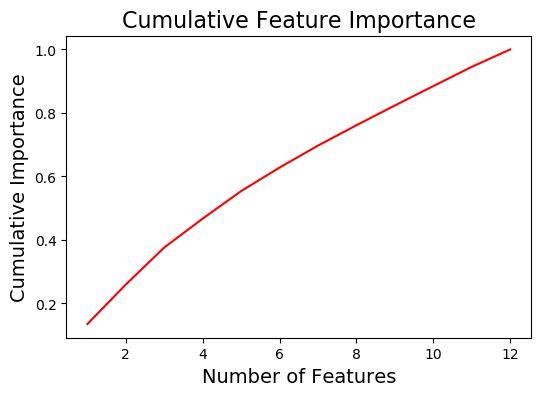

In [6]:
new_db = filtered_db
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number'], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)
# X = X.drop([i for i in X.columns if "KL" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

with io.capture_output() as captured:
    fs = FeatureSelector(data = X, labels = Y)
    fs.identify_missing(missing_threshold=0.6);
    fs.identify_single_unique()
    fs.identify_collinear(correlation_threshold=0.975)
    # fs.plot_collinear(plot_all=True)
    fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                                n_iterations = 10, early_stopping = True)
fs.plot_feature_importances(plot_n = 10)


# Print the crossvalidation score:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=1)
s = cross_val_score(model, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Accuracy: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.var(s)))


# df.plot.bar(rot=90)

features_0 = fs.feature_importances
fs.feature_importances

## Classifying presense of KL with all the same data

[ True  True  True ...,  True  True  True]
13076
2


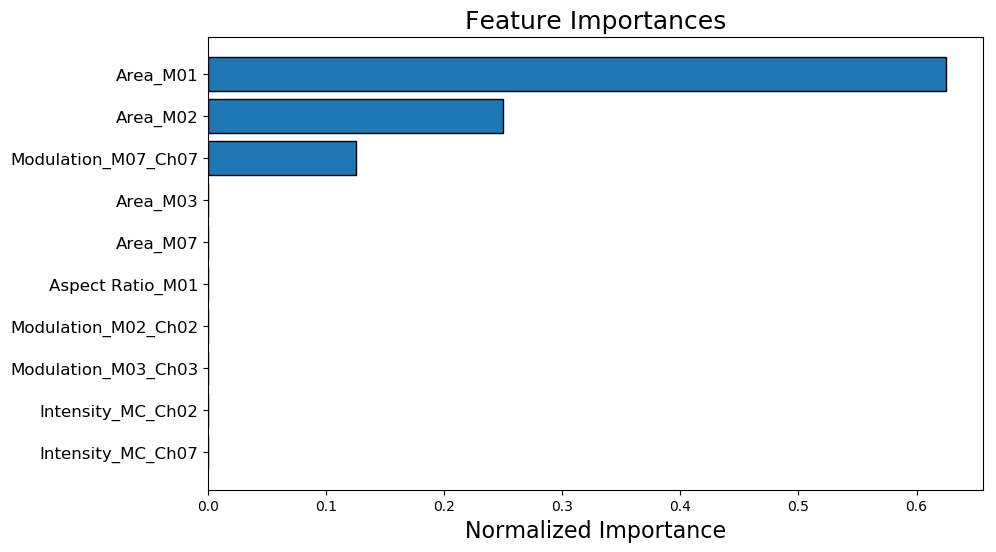

/home/ankitb/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:651: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)


Cross-validation Accuracy: 0.988834758641
Cross-validation Variance: 0.000327339610472


,feature,importance,normalized_importance,cumulative_importance
0,Area_M01,5.0,0.625,0.625
1,Area_M02,2.0,0.250,0.875
2,Modulation_M07_Ch07,1.0,0.125,1.000
3,Area_M03,0.0,0.000,1.000
4,Area_M07,0.0,0.000,1.000
5,Aspect Ratio_M01,0.0,0.000,1.000
6,Modulation_M02_Ch02,0.0,0.000,1.000
7,Modulation_M03_Ch03,0.0,0.000,1.000
8,Intensity_MC_Ch02,0.0,0.000,1.000
9,Intensity_MC_Ch07,0.0,0.000,1.000


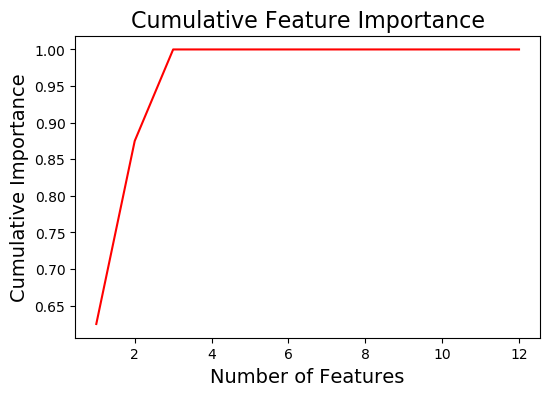

In [9]:
new_db = filtered_db
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Intensity_MC_KL.to_numpy()
Y = Y>0 # young =1 old = 0
print(Y)
print(np.count_nonzero(Y))
print(Y.shape[0] - np.count_nonzero(Y))

X = new_db.drop(['Class', 'Object Number'], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)
# X = X.drop([i for i in X.columns if "KL" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

with io.capture_output() as captured:
    fs = FeatureSelector(data = X, labels = Y)
    fs.identify_missing(missing_threshold=0.6);
    fs.identify_single_unique()
    fs.identify_collinear(correlation_threshold=0.975)
    # fs.plot_collinear(plot_all=True)
    fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                                n_iterations = 10, early_stopping = True)
fs.plot_feature_importances(plot_n = 10)


# Print the crossvalidation score:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=1)
s = cross_val_score(model, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Accuracy: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.var(s)))


# df.plot.bar(rot=90)

features_0 = fs.feature_importances
fs.feature_importances

In [ ]:
## What if we tried to put a boundary on it

[ True  True False ..., False False False]
4558
8518


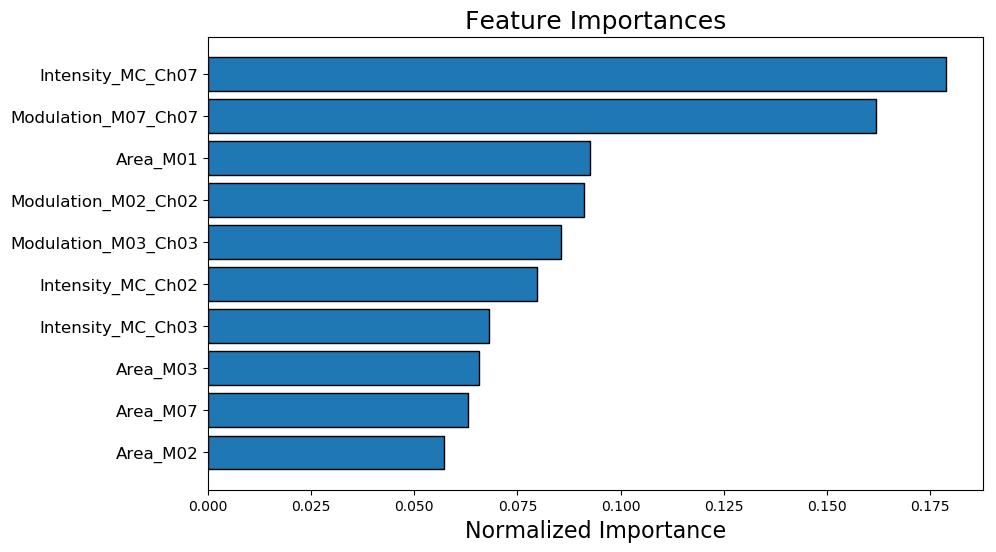

Cross-validation Accuracy: 0.94845453181
Cross-validation Variance: 2.67457049573e-05


,feature,importance,normalized_importance,cumulative_importance
0,Intensity_MC_Ch07,795.0,0.178893,0.178893
1,Modulation_M07_Ch07,720.0,0.162016,0.340909
2,Area_M01,412.0,0.092709,0.433618
3,Modulation_M02_Ch02,405.0,0.091134,0.524752
4,Modulation_M03_Ch03,380.0,0.085509,0.610261
5,Intensity_MC_Ch02,354.0,0.079658,0.689919
6,Intensity_MC_Ch03,303.0,0.068182,0.758101
7,Area_M03,292.0,0.065707,0.823807
8,Area_M07,280.0,0.063006,0.886814
9,Area_M02,254.0,0.057156,0.943969


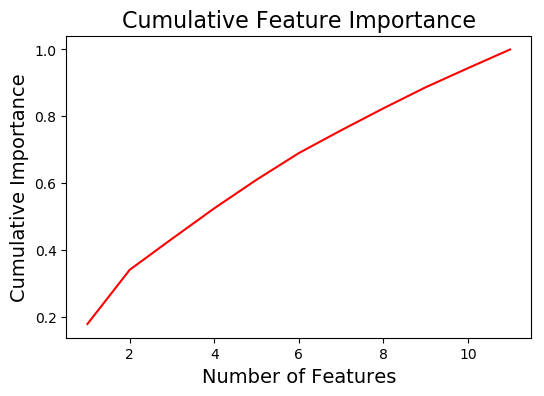

In [23]:
new_db = filtered_db
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Intensity_MC_KL.to_numpy()
Y = Y>30# KL_positive is greater than 30 and negative is less than 30
print(Y)
print(np.count_nonzero(Y))
print(Y.shape[0] - np.count_nonzero(Y))

X = new_db.drop(['Class', 'Object Number'], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)
X = X.drop([i for i in X.columns if "KL" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

with io.capture_output() as captured:
    fs = FeatureSelector(data = X, labels = Y)
    fs.identify_missing(missing_threshold=0.6);
    fs.identify_single_unique()
    fs.identify_collinear(correlation_threshold=0.975)
    # fs.plot_collinear(plot_all=True)
    fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                                n_iterations = 10, early_stopping = True)
fs.plot_feature_importances(plot_n = 10)


# Print the crossvalidation score:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, verbose=1)
s = cross_val_score(model, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Accuracy: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.var(s)))


# df.plot.bar(rot=90)

features_0 = fs.feature_importances
fs.feature_importances

## Fig. 2D, 2E, 3G: Rug plots

## Means, Variances and mann-whitney tests

In [13]:
young = filtered_db[(filtered_db.Class==1)]
old = filtered_db[(filtered_db.Class==0)]
# points_young = analysis.points_young
# points_old = analysis.points_old
hist_range = [[0,150],[0,150],[0,25],[0,2000],[0,10000],[0,100]]
age = ['Old', 'Young']
series = ['Intensity_MC_Ch02', 
         'Intensity_MC_Ch07',
         'Intensity_MC_KL',]
for s in series:
    print('\n' + s)
    print('[Old]')
    print('Mean: ' + str(old[s].mean()))
    print('Var: ' + str(old[s].var()))
    print('[Young]')
    print('Mean: ' + str(young[s].mean()))
    print('Var: ' + str(young[s].var()))
    print('MannWhitney U Test p-value: ' + str(mannwhitneyu(old[s], young[s])[1]))




Intensity_MC_Ch02
[Old]
Mean: 36.6039867888
Var: 713.039885018
[Young]
Mean: 33.0910392707
Var: 244.143357191
MannWhitney U Test p-value: 0.000150485406513

Intensity_MC_Ch07
[Old]
Mean: 0.656163564029
Var: 0.271867143213
[Young]
Mean: 0.688625214275
Var: 0.445406813515
MannWhitney U Test p-value: 1.5857624148e-07

Intensity_MC_KL
[Old]
Mean: 32.6781052019
Var: 1262.51229228
[Young]
Mean: 36.8470691133
Var: 2290.18190122
MannWhitney U Test p-value: 0.134853963425


### Rug Plot of CD63:

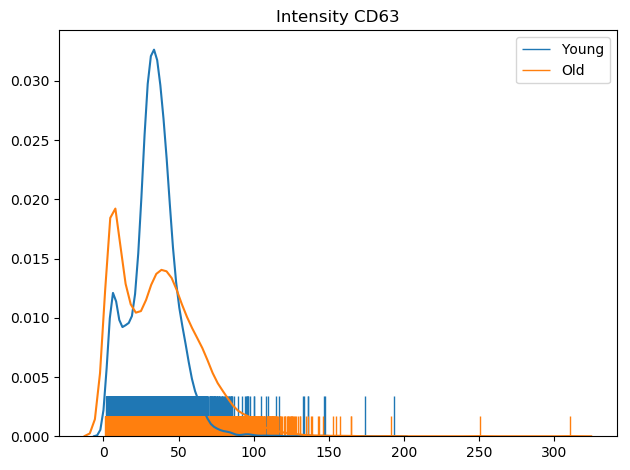

In [14]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 0
plt.figure()
sns.distplot(young.Intensity_MC_Ch02.values,hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(old.Intensity_MC_Ch02.values,hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title(labels[i])
plt.tight_layout()
plt.savefig('../generated_figures/cd63_rug_plt.eps', format='eps')
plt.show()


### Rug Plot of CD81

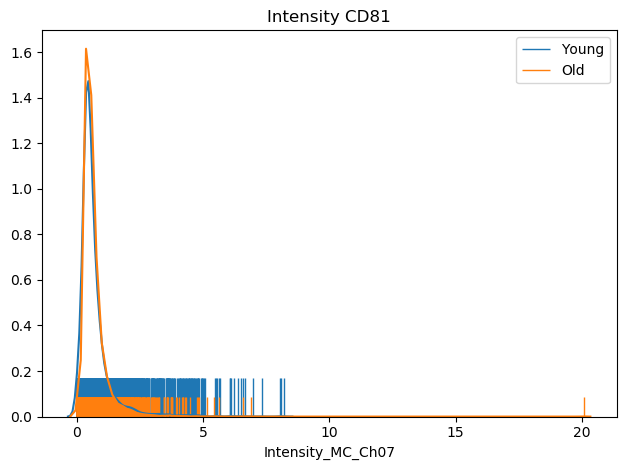

In [15]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 1
plt.figure()
sns.distplot(young.Intensity_MC_Ch07.values,hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(old.Intensity_MC_Ch07,hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title(labels[i])
plt.tight_layout()
p = plt.savefig('../generated_figures/cd81_rug_plt.eps', format='eps')
p = plt.show()

### Rug plot of KLotho

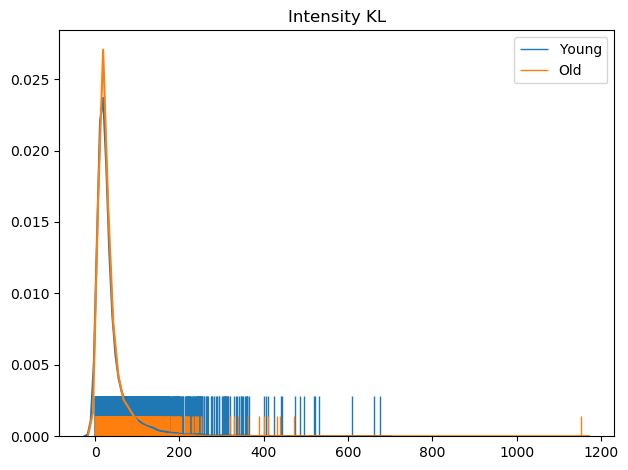

In [16]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 1
fig = plt.figure()
sns.distplot(young.Intensity_MC_KL.values,hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(old.Intensity_MC_KL.values,hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title('Intensity KL')
plt.tight_layout()
plt.savefig('../generated_figures/KL_rug_plt.eps', format='eps')
plt.show()

## Fig. 3I: What features predict ch11 and ch4 activation? Both are Klotho but different forms of it. 

We explore this question by looking at the correlation between all features and then specifically the correlation of all features to the level of KL in young old and combined populations. 

0 features with greater than 0.60 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.97.



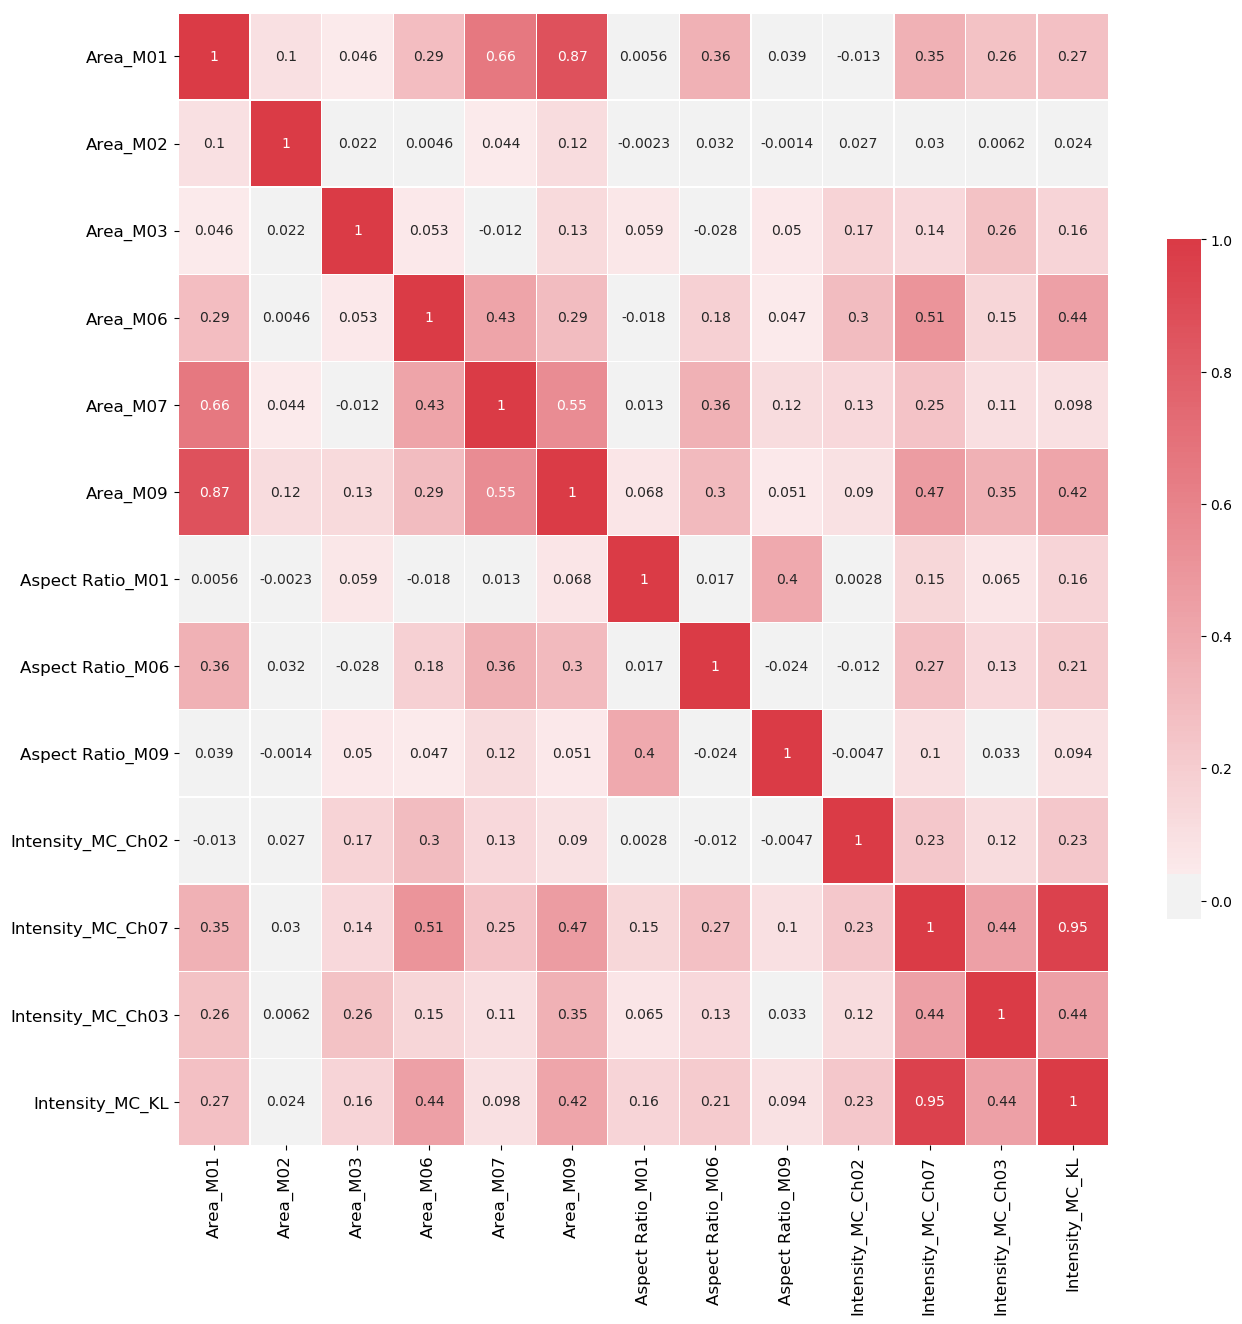

In [17]:
new_db = filtered_db
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = unfiltered_db.Intensity_MC_Ch11.to_numpy()
Y = Y>0 # ch11> = 1, ch11< = 0
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
# X = X.drop([i for i in X.columns if "03" in i] , axis=1)
# X = X.drop([i for i in X.columns if "KL" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)
X = X.drop([i for i in X.columns if "Modulation" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)
fs = FeatureSelector(data = X, labels = Y)
fs.identify_missing(missing_threshold=0.6)
fs.identify_single_unique()
fs.identify_collinear(correlation_threshold=0.975)
corr_mat = fs.corr_matrix
fs.corr_matrix.to_csv('correlation matrix.csv')
f,ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(corr_mat, cmap = cmap, center = 0, linewidth=0.25, cbar_kws={"shrink": 0.6}, annot=True)

ax.set_yticks([x + 0.5 for x in list(range(corr_mat.shape[0]))])
ax.set_yticklabels(list(corr_mat.index), size = int(160 / corr_mat.shape[0]));
ax.set_xticks([x + 0.5 for x in list(range(corr_mat.shape[0]))])
ax.set_xticklabels(list(corr_mat.index), size = int(160 / corr_mat.shape[1]));

plt.show()
plt.savefig('../generated_figures/all_corr.eps', format='eps')

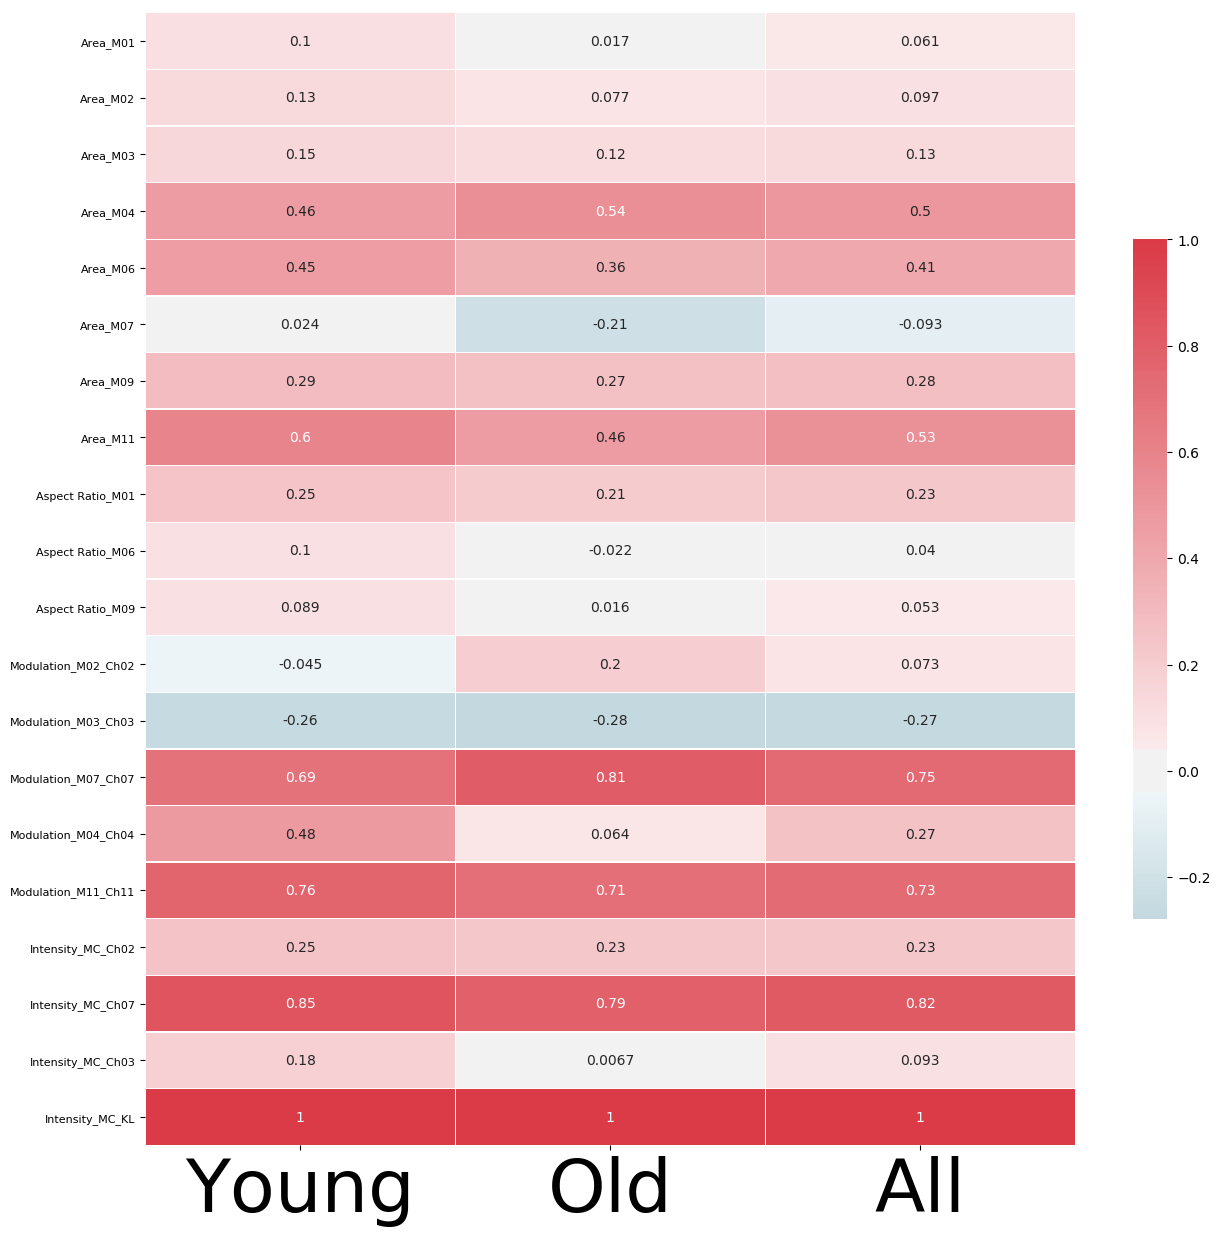

In [18]:
# Making the weird correlation matrix 

young_corr = filtered_db[(filtered_db.Class==1)].corr(method='spearman')
old_corr = filtered_db[(filtered_db.Class==0)].corr(method='spearman')
all_corr = filtered_db.corr(method='spearman')

data = np.array([young_corr.Intensity_MC_KL.values, old_corr.Intensity_MC_KL.values, all_corr.Intensity_MC_KL.values])
df = pd.DataFrame(data = data.transpose(), index = young_corr.index, columns = ['Young', 'Old', 'All'])
indices = ['Class', 'Object Number','Intensity_MC_Ch04', 'Intensity_MC_Ch11']
df.drop(index=indices, inplace=True)
df.head()

f,ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220,10, as_cmap=True)
sns.heatmap(df, cmap = cmap, center = 0, linewidth=0.25, cbar_kws={"shrink": 0.6}, annot=True)

ax.set_yticks([x + 0.5 for x in list(range(df.shape[0]))])
ax.set_yticklabels(list(df.index), size = int(160 / df.shape[0]));
ax.set_xticks([x + 0.5 for x in list(range(df.shape[1]))])
ax.set_xticklabels(list(df.columns), size = int(160 / df.shape[1]));

plt.savefig('../generated_figures/young-old-corr.eps',format='eps')
plt.show()




## Fig. 3J: Correlation between ch7 and ch11. 

In [19]:
#. Cluster the two populations
X = filtered_db[['Intensity_MC_Ch07', 'Intensity_MC_KL']]
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
clus = KMeans().fit(x_scaled)
labels = clus.labels_

0
[0 1 2 3 4 5 6 7]
[5864  113 1796   30  337 4112  825    1]
('Points start', (13078, 24))
('Points left', (13076, 24))


/home/ankitb/.local/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


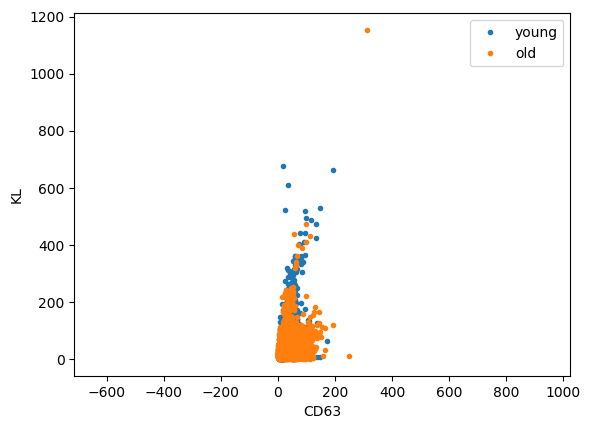

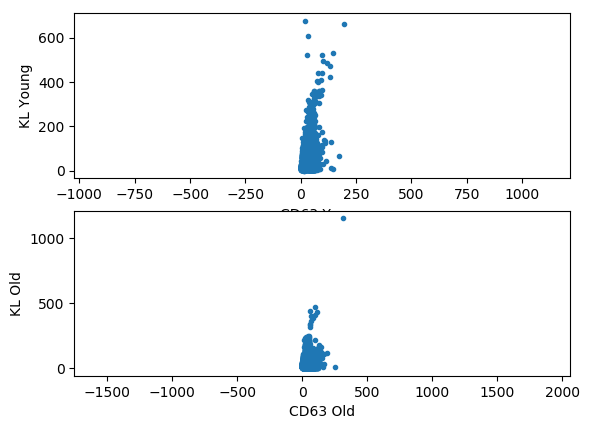

Young Pearson's correlation coefficient
[[ 1.          0.31333449]
 [ 0.31333449  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.21457799]
 [ 0.21457799  1.        ]]


(12540, 24)

In [20]:
clusters, size = np.unique(labels, return_counts=True)
best_cluster = clusters[np.argmax(size)]
print(best_cluster)
print(clusters)
print(size)
non_zeroes = np.where(labels==best_cluster)
c0_index = (non_zeroes[0])
c0db = filtered_db.iloc[c0_index]

new_db = filtered_db
print('Points start', new_db.shape)
new_db_index = new_db[(new_db.Intensity_MC_KL<100) & (new_db.Intensity_MC_Ch07>4)].index
new_db.drop(new_db_index , inplace=True)
print('Points left', new_db.shape)
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_kl_intensity = new_db[(new_db.Class==1)].Intensity_MC_KL
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_kl_intensity = new_db[(new_db.Class==0)].Intensity_MC_KL

plt.plot(young_ch7_intensity, young_kl_intensity, '.')
plt.plot(old_ch7_intensity, old_kl_intensity,'.')
plt.legend(['young', 'old'])
plt.xlabel('CD63')
plt.ylabel('KL')
plt.axis('equal')
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_kl_intensity, '.')
plt.xlabel('CD63 Young')
plt.ylabel('KL Young')
plt.axis('equal')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_kl_intensity,'.')
plt.xlabel('CD63 Old')
plt.ylabel('KL Old')
# plt.legend(['young', 'old'])
plt.axis('equal')
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_kl_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_kl_intensity))


#. Cluster the two populations
X = filtered_db[['Intensity_MC_Ch07', 'Intensity_MC_KL']]
kmeans = KMeans(n_clusters=4, random_state=2).fit(X)
labels = kmeans.labels_
non_zeroes = np.nonzero(labels-1)
c0_index = (non_zeroes[0])
non_zeroes = np.nonzero(labels)
c1_index = (non_zeroes[0])
c1db = filtered_db.iloc[c0_index]
c1db.shape